In [1]:
# Basic set of Python Data Analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.width',180)
pd.set_option('display.max_colwidth', 20)

## for plot by matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from cycler import cycler
import seaborn as sns

# for plot by matplotlib
sns.set(font="DejaVu Sans", font_scale=1.8,
        rc={'figure.figsize': (10, 10),
            'lines.markersize': 15,
            "animation.embed_limit": 100})
sns.mpl.rc("axes", prop_cycle
           =cycler('color', ['#E24A33', '#348ABD', '#988ED5',
                             '#777777', '#FBC15E', '#8EBA42',
                             '#FFB5B8']))
sns.set_style('darkgrid', {'axes.facecolor': "0.8"})

# for markers
marker = itertools.cycle(('o', 'v', '^', 'D', '+', 'X', '<', '>'))
colors = itertools.cycle(('#E24A33', '#348ABD', '#988ED5', '#777777',
                          '#FBC15E', '#8EBA42', '#FFB5B8'))


## for machine learning with scikit learn
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

## PCCA+ from pyemma
from pyemma.msm import PCCA
from pyemma.coordinates import tica

## don't show warning
import warnings
warnings.filterwarnings('ignore')

# import the Escal Tools
import os, sys
sys.path.append(os.path.expanduser("../../toolkits"))
import basicTools as bt
import Etranform as et
import mapTools.linear as mt
from importlib import reload

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Parameters

In [2]:
## the data directory
## the data directory
datadir = os.path.realpath("../../data")
fname = "425"
filePref = f"{datadir}/{fname}"
print("The analysis will do for: \n", filePref)

## The data per frames
skip = 1

### smooth
step    = 100
width   = 200
seg2vec = bt.segment.medoid

### similar metrix
similar = bt.dist.cosin

### evalute method
evalute = bt.evalute.cluster

The analysis will do for: 
 /home/ghzuo/data/gromacs/data.Chignolin/5awl/unfolding/425


# The Input Data

## Structure of Trajectory

In [3]:
## read data from file
dih = pd.DataFrame(np.loadtxt(f"{filePref}-rama.xvg", comments=["@","#"],
                             dtype = {'names': ('Phi', 'Psi', 'Residue'),
                                     'formats': ('f', 'f', 'S7')}))
print("The shape of input file is: ", dih.shape)
X0 = bt.feature.dih2X(dih)
X0 = X0.loc[1::skip,:].reset_index(drop=True)
X0 = np.array(X0)
print("The shape of X0 is: ", X0.shape)
Xx = (X0 - np.mean(X0, axis=0))/np.std(X0,axis=0)
print("The shape of Xx is: ", Xx.shape)

The shape of input file is:  (800008, 3)
The shape of X0 is:  (100000, 32)
The shape of Xx is:  (100000, 32)


## Energy of Trajectory

In [4]:
## read the energy data
eng = pd.DataFrame(np.loadtxt(f"{filePref}-potential.xvg", comments=["@","#"],
                             dtype = {'names': ('time', 'energy'), 
                                     'formats': ('f', 'f')}))

### base frequence in MHz
## 1000,000 for M and P, and 2 for even extension
ufreq = 500000/eng.loc[len(eng)-1, "time"]
print("The base frequence is {:.4f} MHz".format(ufreq))

E0 = np.array(eng.loc[1::skip, 'energy'])
print("The shape of Energy is: ", E0.shape)

The base frequence is 0.5000 MHz
The shape of Energy is:  (100000,)


## RMSD from Native Structure

In [5]:
rms = np.loadtxt(f"{filePref}-CaRMS.xvg", comments=["@","#"],
                 dtype = {'names': ('time', 'rms'), 
                          'formats': ('f', 'f')})
rms = rms[1::skip]
print("The shape of RMS is: ", rms.shape)

The shape of RMS is:  (100000,)


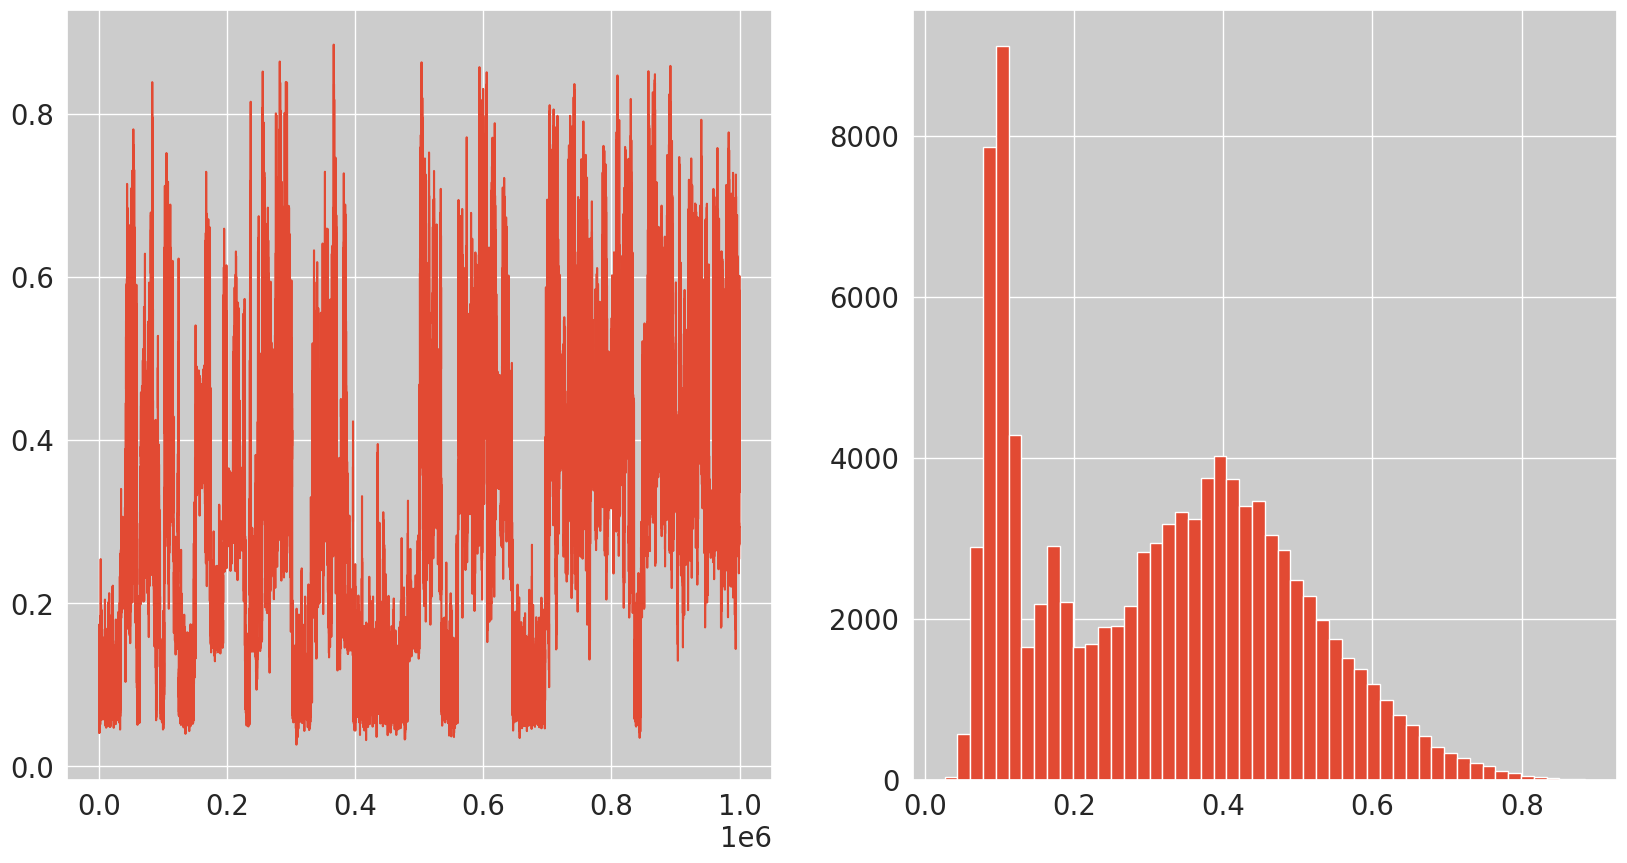

In [6]:
plt.figure(12,figsize=(20,10))
ax = plt.subplot(121)
ax.plot(rms['time'], rms['rms'])
ax = plt.subplot(122)
hist = ax.hist(rms["rms"], bins=50, )

# Score of Frequence

In [7]:
## do FFT rescaling
efft = et.Efft(Xx, E0)

## set the mapping tool
xmap = mt.LinearRegress(efft)

## get the score
qmc = xmap.score(kmax=50)

Text(51.7, 0.7500581721856021, '#47 (23.0 MHz)\nQMC = 0.78')

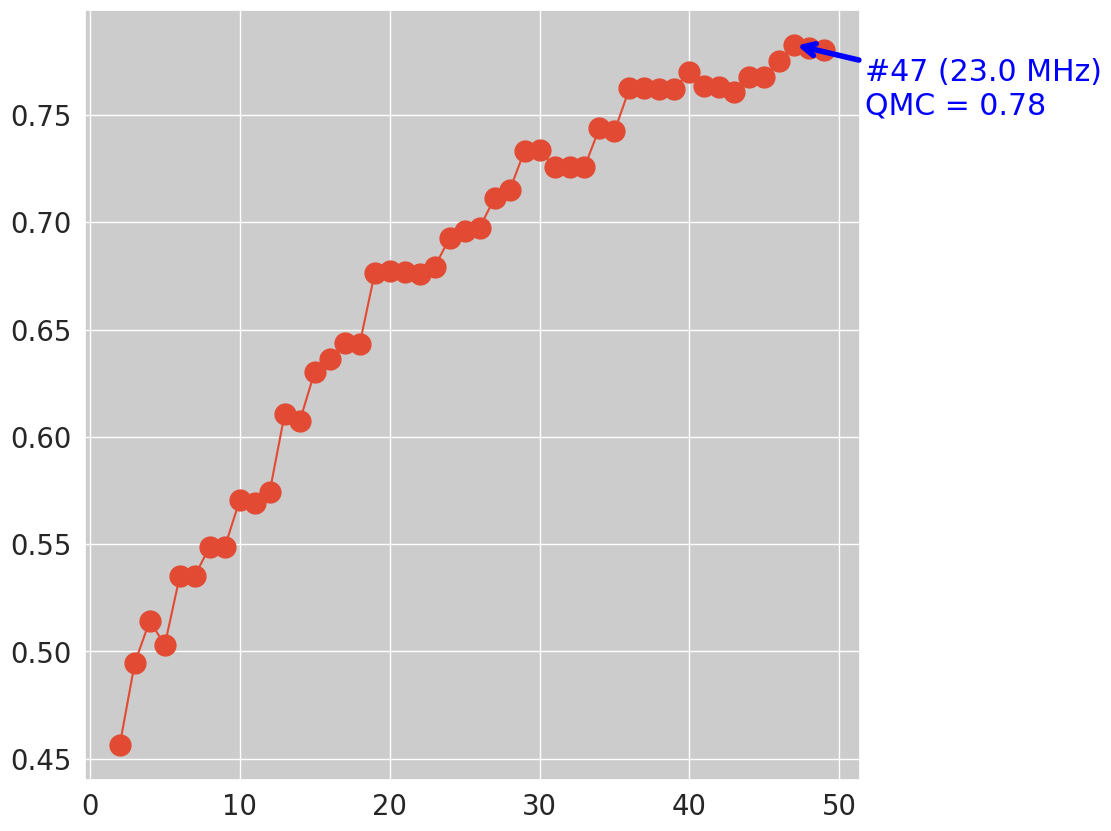

In [8]:
## plot the multiple correlation coefficient
plt.plot(qmc['list'][:,0],qmc['list'][:,1], marker="o")

## annotate the peak value
xy     = (qmc['KappaMax'], qmc['qmcMax'])
offset = 0.1 * (np.max(qmc['list'], axis=0)-np.min(qmc['list'],axis=0))
xytxt  = [xy[0] + offset[0], xy[1] - offset[1]]
plt.annotate("#{:d} ({:.1f} MHz)\nQMC = {:.2f}"
            .format(int(xy[0]), (xy[0]-1)*ufreq, xy[1]), 
            xy=xy, xytext=xytxt, color='blue', 
            arrowprops=dict(arrowstyle="->", color='blue', lw=4))

# Scaling for Selected Kappa

In [9]:
kappa = qmc['KappaMax']
rescl = xmap.scale(kappa)

## Weight of Features

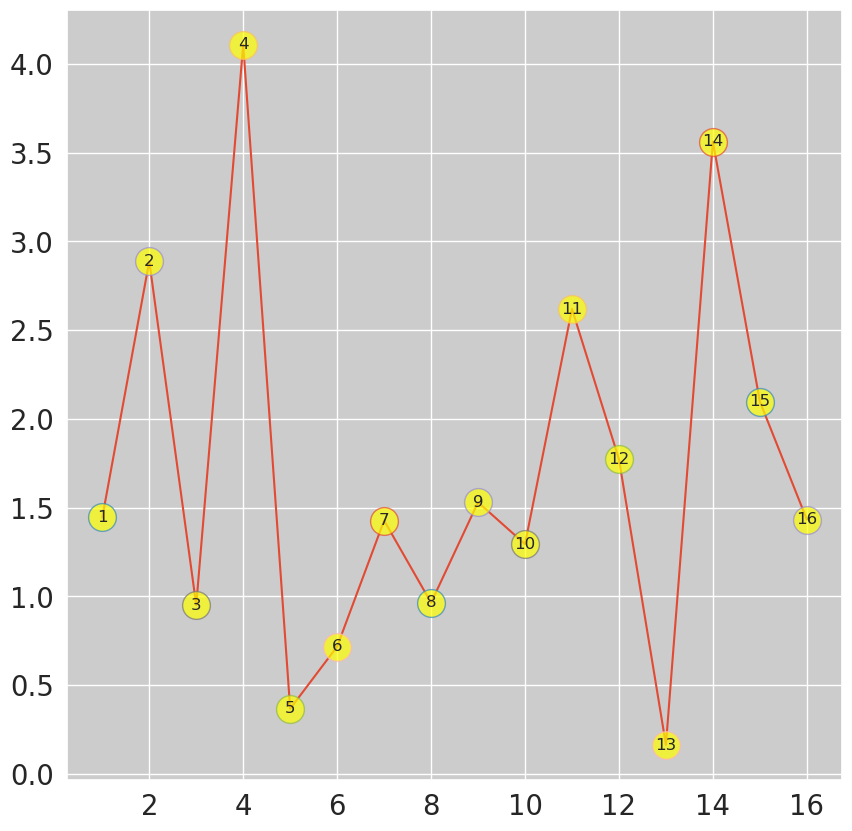

In [10]:
bt.plot.coefplot(bt.feature.dihCombind(rescl['A']))

## Effective Energy

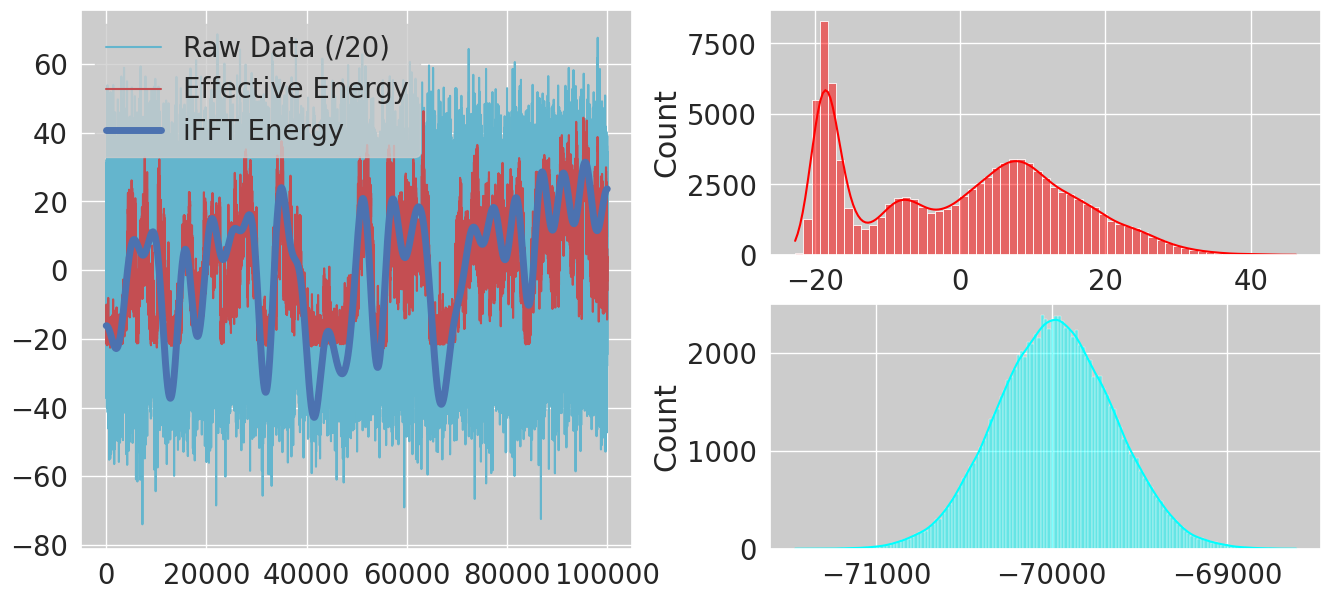

In [11]:
## plot the effective energy
bt.plot.efplot(E0, efft.Ef(kappa), rescl['Ee'])

## Distribution & Free Energy

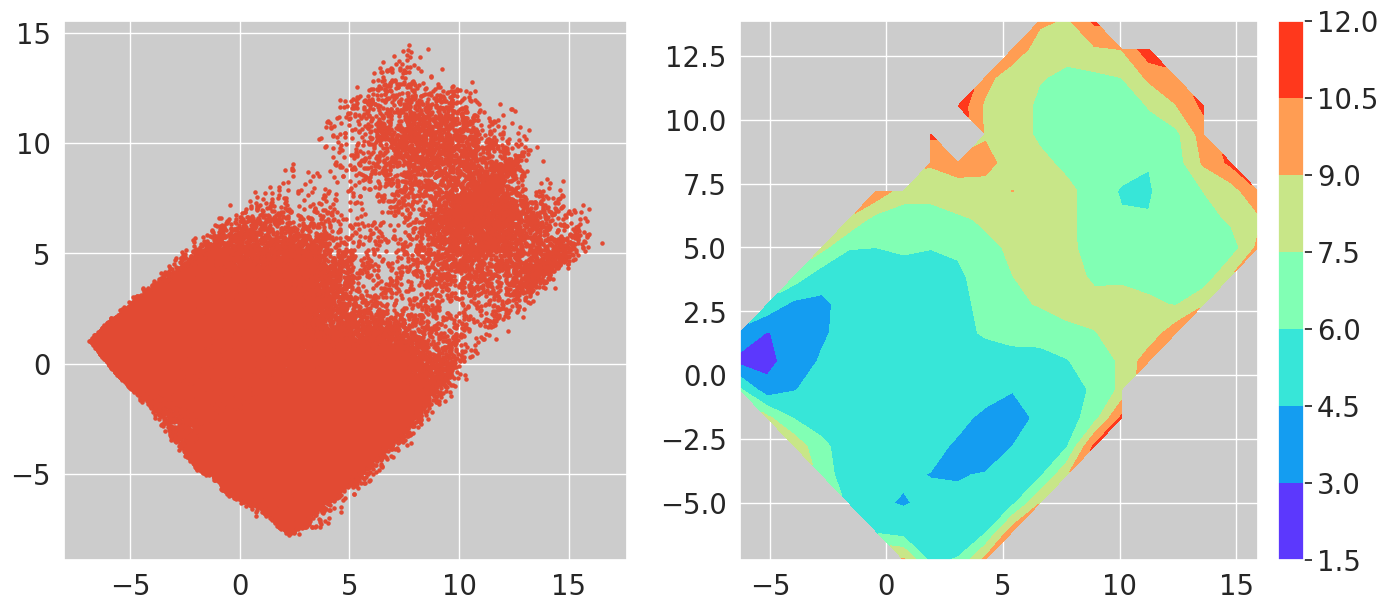

In [12]:
pca = PCA(n_components = 2)
bt.plot.distr_plot(pca.fit_transform(rescl['X']))

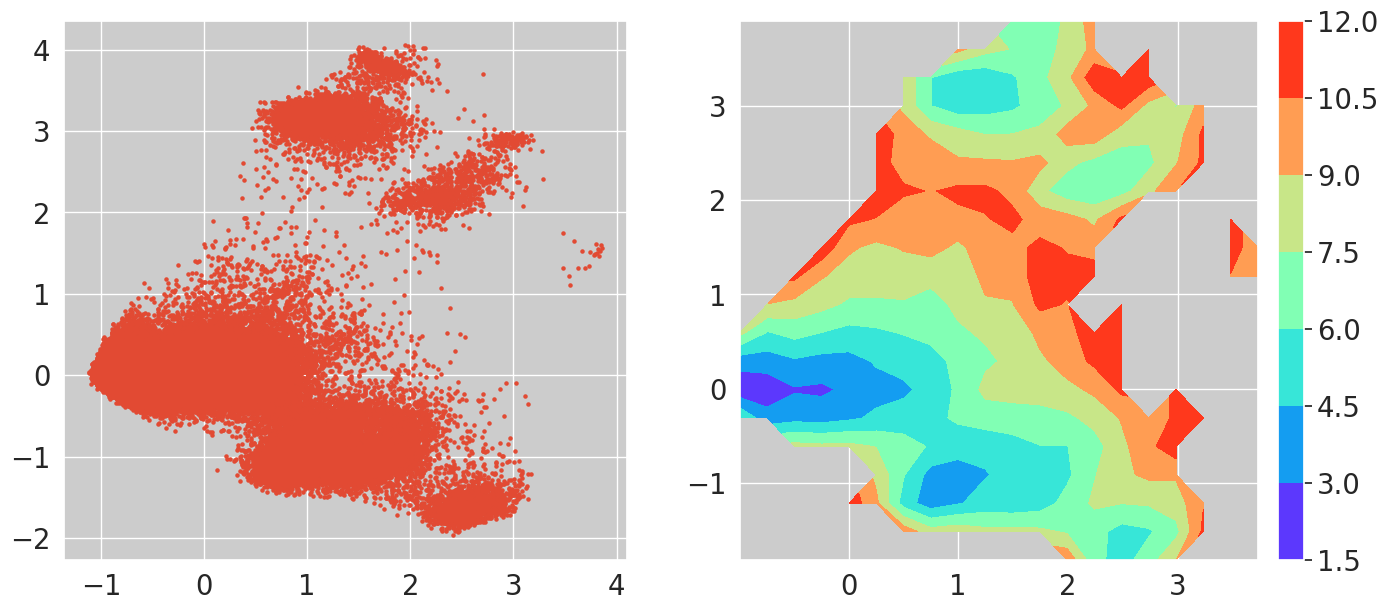

In [28]:
bt.plot.distr_plot(tica(rescl['X'],dim=2, lag=50).get_output()[0])

# Matrix Analysis

## Sample Data

In [14]:
## get the samples
X0s = seg2vec(X0, step, width)
Xys = seg2vec(rescl['X'], step, width)

## Testing Similarity Matrix

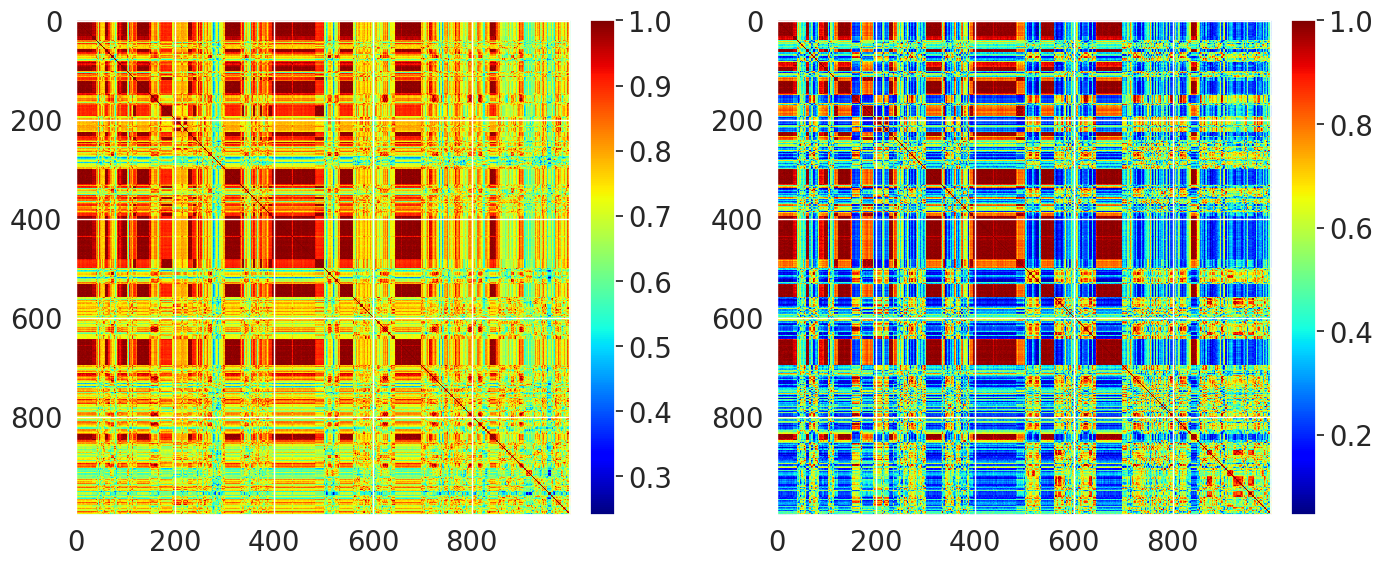

In [15]:
## set distance function and get distance
Smat0  = similar(X0s)
Smaty  = similar(Xys)
    
### plot
fig, axs = plt.subplots(1,2, figsize=(16,32))
fig.subplots_adjust(wspace=0.3)
bt.plot.implot(Smat0, axs[0])
bt.plot.implot(Smaty, axs[1])

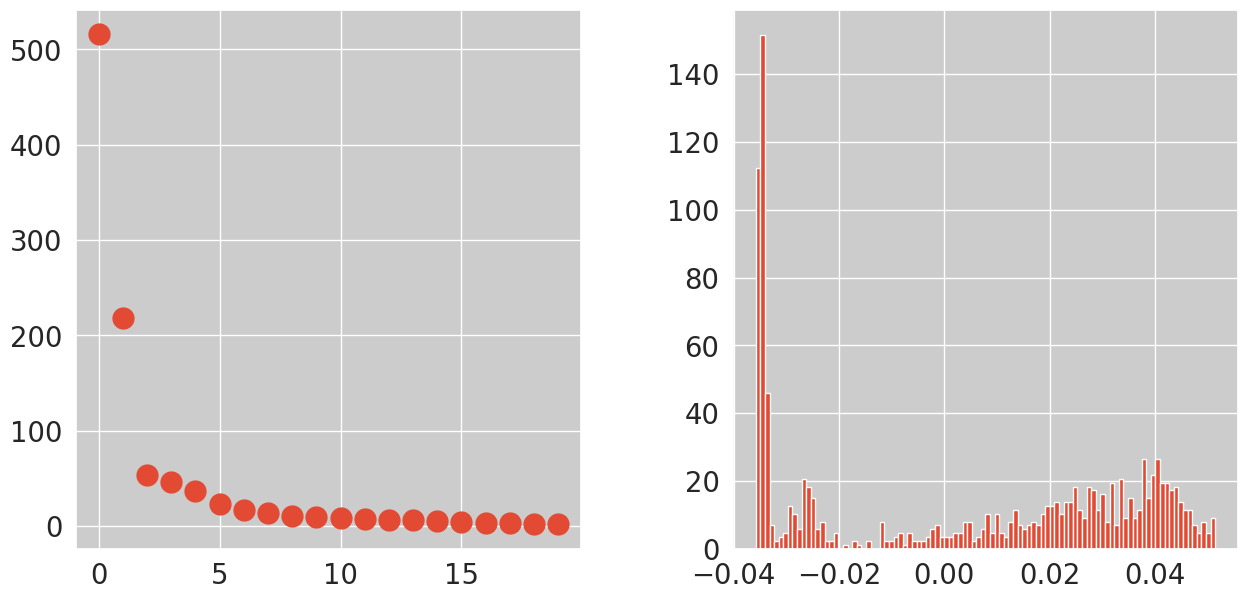

In [16]:
w,v = np.linalg.eig(Smaty)

fig, axs = plt.subplots(1,2, figsize=(15,7))
fig.subplots_adjust(wspace=0.3)
axs[0].plot(w[0:20], "o")
hist = axs[1].hist(v[:,1], bins=100, density=True)

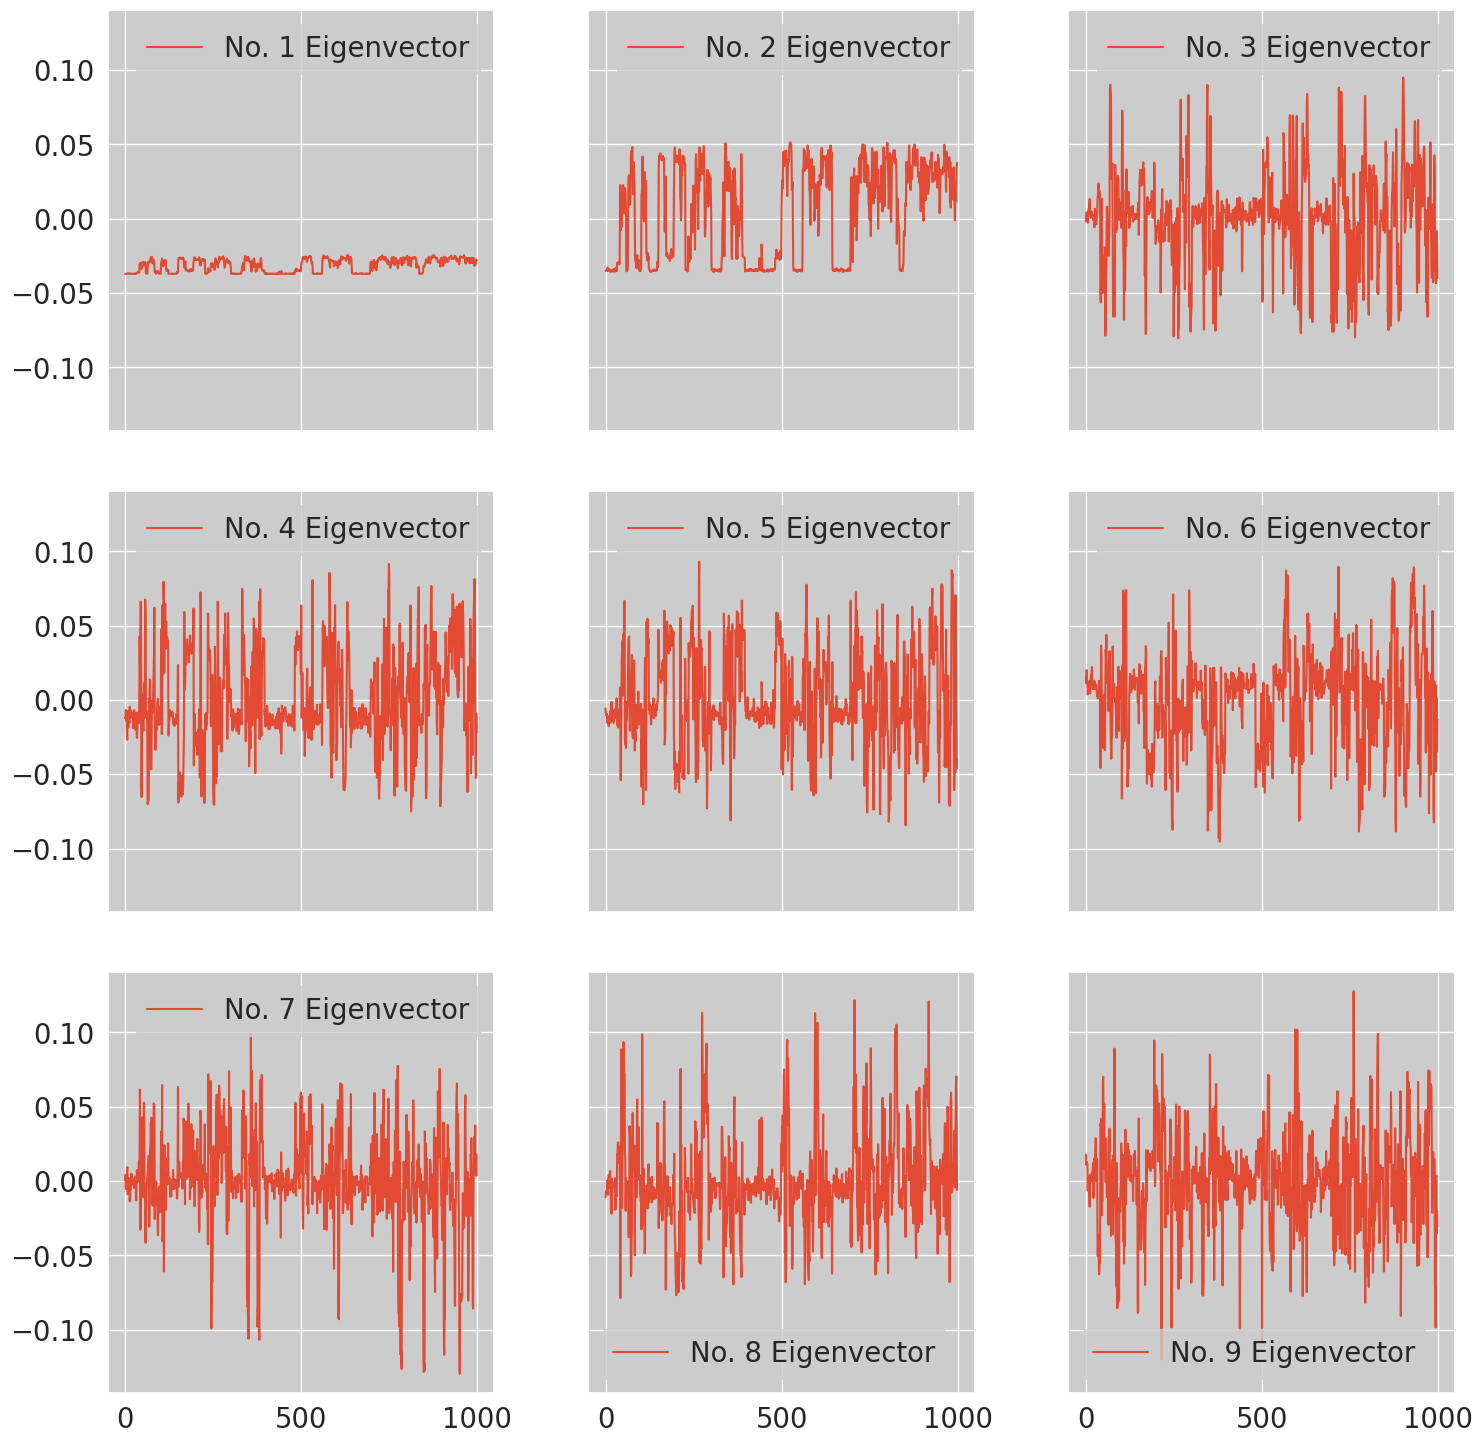

In [17]:
fig, axs = plt.subplots(3,3,sharex=True,sharey=True, figsize=(15,15)) 
sel = range(0,np.size(axs))
fig.tight_layout()
for ax, key in zip(axs.reshape(len(sel)), sel): 
    ax.plot(v[:,key])
    ax.legend(labels =["No. " + str(key+1) + " Eigenvector"])

# Save Data

In [18]:
## save current ipynb
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')

In [27]:
## record output to pdf
#nbname = os.path.basename(app.sessions.get_state().get('current_session').get('path'))
nbname = 'EscalMSM-soloTraj.ipynb'
srcpath = %pwd
srcfile = f"{srcpath}/{nbname}"

!jupyter nbconvert --to pdf --no-input --log-level 40 \
    --output-dir {datadir} --output "EscalMSM-"{fname}".pdf" \
    {srcfile}